In [19]:
# !pip install pypdf

#  Understanding Corrective RAG (CRAG)

## What is RAG?
RAG = Retrieval-Augmented Generation  

1. The model takes your question.  
2. It retrieves candidate documents from an external source (like a vector database).  
3. It generates an answer using both the retrieved information and its own reasoning.  

**Problem**: If retrieval is noisy or irrelevant, the final answer can be wrong or hallucinated.

---

## What is Corrective RAG?
Corrective RAG (CRAG) improves RAG by **checking and correcting** the retrieval step before generation.  

The process:  
1. Retrieve documents → Fetch candidate chunks.  
2. Grade relevance → Evaluate if each document is truly connected to the user question.  
3. Filter → Keep only relevant documents, discard irrelevant ones.  
4. Correct query → If no good documents are found, rewrite the query and try retrieving again.  
5. Generate answer → Use only trusted, relevant documents for the final response.  

---

## Analogy
- Plain RAG: You ask a friend a question, they bring a pile of books that *might* help, and they try to answer immediately.  
- Corrective RAG: The friend skims the books, discards irrelevant ones, and if none are useful, they rephrase your question and search again. Only then do they answer.  

---

## Benefits
- Reduces hallucinations by removing irrelevant context.  
- Produces more accurate and trustworthy answers.  
- Adds robustness since it can retry if the first retrieval attempt fails.  

---

## Key Takeaway
Corrective RAG = **RAG + a filtering and correction loop**.  
It makes retrieval smarter and more reliable by validating documents and refining queries before generating the final answer.


![Agentic Rag Workflow](CORRECTIVE_RAG.png)

<img src="CORRECTIVE_RAG_LANGGRAPH.png" alt="Uploaded Picture" width="300">


In [13]:
# ------------------------------------------------
# 🔑 Step 1: Load Environment Variables
# ------------------------------------------------
import os
from dotenv import load_dotenv

# Load variables from .env file into environment
load_dotenv()   # This will make .env values accessible via os.getenv()

# ------------------------------------------------
# 🔑 Step 2: Set API Keys in Environment
# ------------------------------------------------
# Retrieve from .env and assign explicitly to os.environ
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")
os.environ["TAVILY_API_KEY"] = os.getenv("TAVILY_API_KEY")

# ------------------------------------------------
# 🔑 Step 3: Verify Keys Loaded (Optional - for debugging only)
# ------------------------------------------------
print("✅ OPENAI_API_KEY loaded:", bool(os.environ.get("OPENAI_API_KEY")))
print("✅ TAVILY_API_KEY loaded:", bool(os.environ.get("TAVILY_API_KEY")))


✅ OPENAI_API_KEY loaded: True
✅ TAVILY_API_KEY loaded: True


In [14]:
# ------------------------------------------------
# 📦 Imports for Data Loading, Splitting & Embeddings
# ------------------------------------------------

# 🔹 Split large documents into manageable chunks
from langchain.text_splitter import RecursiveCharacterTextSplitter

# 🔹 Load documents directly from web pages
from langchain_community.document_loaders import WebBaseLoader

# 🔹 Vector database (FAISS) to store embeddings and enable fast similarity search
from langchain_community.vectorstores import FAISS

# 🔹 OpenAI embeddings model for text → vector conversion
from langchain_openai import OpenAIEmbeddings


In [20]:
# ------------------------------------------------
# 📂 Build Index from PDFs
# ------------------------------------------------
from langchain_community.document_loaders import PyPDFLoader

# ------------------------------------------------
# 🧩 Step 1: Set embeddings
# ------------------------------------------------
embd = OpenAIEmbeddings()

# ------------------------------------------------
# 🧩 Step 2: Load documents (PDFs instead of URLs)
# ------------------------------------------------
pdf_files = [
    'digital_transformation.pdf',
 'HealthCareSectorinindia-AnOverview.pdf']


docs = []
for file in pdf_files:
    loader = PyPDFLoader(file)
    docs.extend(loader.load())   # PyPDFLoader already returns a list of Documents

print(f"✅ Loaded {len(docs)} pages from {len(pdf_files)} PDFs")

# ------------------------------------------------
# 🧩 Step 3: Split into chunks
# ------------------------------------------------
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=500,   # max characters per chunk
    chunk_overlap=0   # no overlap for compact indexing
)
doc_splits = text_splitter.split_documents(docs)

print(f"✅ Created {len(doc_splits)} chunks")

# ------------------------------------------------
# 🧩 Step 4: Build vectorstore (FAISS)
# ------------------------------------------------
vectorstore = FAISS.from_documents(
    documents=doc_splits,
    embedding=embd
)

# ------------------------------------------------
# 🧩 Step 5: Create retriever
# ------------------------------------------------
retriever = vectorstore.as_retriever()

print("✅ Retriever ready!")


✅ Loaded 36 pages from 2 PDFs
✅ Created 192 chunks
✅ Retriever ready!


In [22]:
# ------------------------------------------------
# 🎯 Retrieval Grader
# ------------------------------------------------
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI
from pydantic import BaseModel, Field

# ------------------------------------------------
# 🧩 Step 1: Define Output Schema
# ------------------------------------------------
class GradeDocuments(BaseModel):
    """Binary score for relevance check on retrieved documents."""
    binary_score: str = Field(
        description="Documents are relevant to the question: 'yes' or 'no'"
    )

# ------------------------------------------------
# 🧩 Step 2: Initialize LLM with Structured Output
# ------------------------------------------------
llm = ChatOpenAI(
    model="gpt-4.1-nano-2025-04-14",  # adjust if needed
    temperature=0                     # keep deterministic for grading
)
structured_llm_grader = llm.with_structured_output(GradeDocuments)

# ------------------------------------------------
# 🧩 Step 3: Define Grading Prompt
# ------------------------------------------------
system_msg = """
You are a grader assessing the relevance of a retrieved document to a user question.
If the document contains keywords or semantic meaning related to the question,
grade it as relevant.
Give only a binary score: 'yes' or 'no'.
"""

grade_prompt = ChatPromptTemplate.from_messages([
    ("system", system_msg.strip()),
    ("human", "Retrieved document:\n\n{document}\n\nUser question: {question}")
])

# ------------------------------------------------
# 🧩 Step 4: Build the Grading Chain
# ------------------------------------------------
retrieval_grader = grade_prompt | structured_llm_grader

# ------------------------------------------------
# 🧩 Step 5: Test Grader
# ------------------------------------------------
question = "healthcare issues"
docs = retriever.invoke(question)

# pick one retrieved chunk for grading
doc_txt = docs[1].page_content  

# run the grader
result = retrieval_grader.invoke({"question": question, "document": doc_txt})
print("✅ Grading Result:", result)


✅ Grading Result: binary_score='yes'


In [24]:
# ------------------------------------------------
# 📝 Generate Final Answer
# ------------------------------------------------
from langchain import hub
from langchain_core.output_parsers import StrOutputParser
from langchain_openai import ChatOpenAI

# ------------------------------------------------
# 🧩 Step 1: Load RAG Prompt Template
# ------------------------------------------------
# rlm/rag-prompt is a community prompt designed for RAG-style answering
prompt = hub.pull("rlm/rag-prompt")

# ------------------------------------------------
# 🧩 Step 2: Initialize LLM
# ------------------------------------------------
llm = ChatOpenAI(
    model="gpt-4.1-nano-2025-04-14",
    temperature=0.7   # adjust: 0 for deterministic, >0 for more creative
)

# ------------------------------------------------
# 🧩 Step 3: Define Document Formatting Helper
# ------------------------------------------------
def format_docs(docs):
    """Join multiple docs into a single string for the context variable."""
    return "\n\n".join(doc.page_content for doc in docs)

# ------------------------------------------------
# 🧩 Step 4: Build RAG Chain
# ------------------------------------------------
rag_chain = prompt | llm | StrOutputParser()

# ------------------------------------------------
# 🧩 Step 5: Run Generation
# ------------------------------------------------
# Use only the *content* of retrieved docs
context_text = format_docs(docs)

generation = rag_chain.invoke({
    "context": context_text,
    "question": question
})

print("✅ Generated Answer:\n")
print(generation)



✅ Generated Answer:

India faces significant healthcare issues, including limited access to essential drugs, high out-of-pocket costs, and health inequalities across regions and populations. The sector also struggles with infrastructure gaps, a lack of trained professionals, and data management challenges. Despite increasing government funding and digital health trends, many people remain excluded from adequate healthcare services.


In [25]:
# ------------------------------------------------
# 🔄 Question Re-Writer
# ------------------------------------------------
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_openai import ChatOpenAI

# ------------------------------------------------
# 🧩 Step 1: Initialize LLM
# ------------------------------------------------
llm = ChatOpenAI(
    model="gpt-4.1-nano-2025-04-14",  
    temperature=0.7   # higher = more diverse rewrites
)

# ------------------------------------------------
# 🧩 Step 2: Define Prompt for Rewriting
# ------------------------------------------------
system_msg = """
You are a question re-writer that converts an input question into a better version
optimized for web search. Look at the input and reason about the underlying
semantic intent or meaning before rewriting.
"""

re_write_prompt = ChatPromptTemplate.from_messages([
    ("system", system_msg.strip()),
    ("human", "Here is the initial question:\n\n{question}\n\nFormulate an improved question.")
])

# ------------------------------------------------
# 🧩 Step 3: Build Rewriter Chain
# ------------------------------------------------
question_rewriter = re_write_prompt | llm | StrOutputParser()

# ------------------------------------------------
# 🧩 Step 4: Test Rewriter
# ------------------------------------------------
rewritten_question = question_rewriter.invoke({"question": question})
print("✅ Rewritten Question:\n", rewritten_question)


✅ Rewritten Question:
 What are the most common healthcare issues faced globally today?


In [26]:
# ------------------------------------------------
# 🌐 Web Search Tool (Tavily)
# ------------------------------------------------
from langchain_community.tools.tavily_search import TavilySearchResults

# ------------------------------------------------
# 🧩 Step 1: Initialize Tavily Search
# ------------------------------------------------
# k = number of search results to return per query
web_search_tool = TavilySearchResults(k=3)

print("✅ Tavily search tool is ready")


✅ Tavily search tool is ready


In [27]:
# ------------------------------------------------
# 🧩 Graph State Definition
# ------------------------------------------------
from typing import List
from typing_extensions import TypedDict

class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        question   (str): The input user question.
        generation (str): The final LLM-generated answer.
        web_search (str): A flag indicating whether web search should be added.
        documents  (List[str]): List of retrieved or generated documents.
    """
    question: str
    generation: str
    web_search: str
    documents: List[str]

print("✅ GraphState schema defined")


✅ GraphState schema defined


In [28]:
# ------------------------------------------------
# 📥 Retrieve Node
# ------------------------------------------------
from langchain.schema import Document

def retrieve(state):
    """
    Retrieve relevant documents from the vectorstore.

    Args:
        state (dict): The current graph state containing at least the 'question'.

    Returns:
        dict: Updated state with a new key 'documents' holding the retrieved docs.
    """
    print("--- RETRIEVE ---")

    # ------------------------------------------------
    # 🧩 Step 1: Extract Question
    # ------------------------------------------------
    question = state["question"]

    # ------------------------------------------------
    # 🧩 Step 2: Retrieve Documents
    # ------------------------------------------------
    documents = retriever.invoke(question)  # returns List[Document]

    print(f"✅ Retrieved {len(documents)} documents")

    # ------------------------------------------------
    # 🧩 Step 3: Return Updated State
    # ------------------------------------------------
    return {
        "question": question,
        "documents": documents
    }


In [29]:
# ------------------------------------------------
# 📝 Generate Node
# ------------------------------------------------
def generate(state):
    """
    Generate an answer using retrieved documents and the user question.

    Args:
        state (dict): The current graph state containing 'question' and 'documents'.

    Returns:
        dict: Updated state with a new key 'generation' for the LLM output.
    """
    print("--- GENERATE ---")

    # ------------------------------------------------
    # 🧩 Step 1: Extract Inputs
    # ------------------------------------------------
    question = state["question"]
    documents = state["documents"]

    # ------------------------------------------------
    # 🧩 Step 2: Format Documents into Plain Text
    # ------------------------------------------------
    def format_docs(docs):
        return "\n\n".join(doc.page_content for doc in docs)

    context_text = format_docs(documents)

    # ------------------------------------------------
    # 🧩 Step 3: Run RAG Chain
    # ------------------------------------------------
    generation = rag_chain.invoke({
        "context": context_text,
        "question": question
    })

    # ------------------------------------------------
    # 🧩 Step 4: Return Updated State
    # ------------------------------------------------
    return {
        **state,  # preserve all existing keys in the state
        "generation": generation
    }


In [30]:
# ------------------------------------------------
# 📝 Grade Documents Node
# ------------------------------------------------
def grade_documents(state):
    """
    Determines whether the retrieved documents are relevant to the question.

    Args:
        state (dict): The current graph state containing:
                      - question (str)
                      - documents (List[Document])

    Returns:
        dict: Updated state with:
              - documents: only filtered relevant docs
              - web_search: "Yes" if irrelevant docs found, otherwise "No"
    """
    print("--- CHECK DOCUMENT RELEVANCE TO QUESTION ---")

    # ------------------------------------------------
    # 🧩 Step 1: Extract inputs
    # ------------------------------------------------
    question = state["question"]
    documents = state["documents"]

    # ------------------------------------------------
    # 🧩 Step 2: Grade each document
    # ------------------------------------------------
    filtered_docs = []
    web_search = "No"

    for d in documents:
        score = retrieval_grader.invoke({
            "question": question,
            "document": d.page_content
        })
        grade = score.binary_score

        if grade == "yes":
            print("--- GRADE: DOCUMENT RELEVANT ---")
            filtered_docs.append(d)
        else:
            print("--- GRADE: DOCUMENT NOT RELEVANT ---")
            web_search = "Yes"

    # ------------------------------------------------
    # 🧩 Step 3: Return updated state
    # ------------------------------------------------
    return {
        "documents": filtered_docs,
        "question": question,
        "web_search": web_search
    }


In [ ]:
# ------------------------------------------------
# 🔄 Transform Query Node
# ------------------------------------------------
def transform_query(state):
    """
    Rewrites the user question into a better version (optimized for retrieval).

    Args:
        state (dict): The current graph state containing:
                      - question (str)
                      - documents (List[Document])

    Returns:
        dict: Updated state with a re-phrased 'question'
    """
    print("--- TRANSFORM QUERY ---")

    # ------------------------------------------------
    # 🧩 Step 1: Extract inputs
    # ------------------------------------------------
    question = state["question"]
    documents = state["documents"]

    # ------------------------------------------------
    # 🧩 Step 2: Rewrite question
    # ------------------------------------------------
    better_question = question_rewriter.invoke({"question": question})

    # ------------------------------------------------
    # 🧩 Step 3: Return updated state
    # ------------------------------------------------
    return {
        "documents": documents,
        "question": better_question
    }


In [37]:
# ------------------------------------------------
# 🌐 Web Search Node
# ------------------------------------------------
# ------------------------------------------------
# 🌐 Web Search Node (with sources preserved)
# ------------------------------------------------
from langchain.schema import Document

def web_search(state):
    """
    Performs a web search using the (possibly re-phrased) question.

    Args:
        state (dict): The current graph state containing:
                      - question (str)
                      - documents (List[Document])

    Returns:
        dict: Updated state with web search results appended as separate Documents
    """
    print("--- WEB SEARCH ---")

    # ------------------------------------------------
    # 🧩 Step 1: Extract inputs
    # ------------------------------------------------
    question = state["question"]
    documents = state["documents"]

    # ------------------------------------------------
    # 🧩 Step 2: Run web search
    # ------------------------------------------------
    results = web_search_tool.invoke({"query": question})

    # ------------------------------------------------
    # 🧩 Step 3: Convert each search result into a Document with metadata
    # ------------------------------------------------
    for r in results:
        web_doc = Document(
            page_content=r.get("content", ""),
            metadata={"source": r.get("url", "web")}
        )
        documents.append(web_doc)

    # ------------------------------------------------
    # 🧩 Step 4: Return updated state
    # ------------------------------------------------
    return {
        "documents": documents,
        "question": question
    }



In [38]:
# ------------------------------------------------
# 🔀 Decision Node: Generate vs. Transform Query
# ------------------------------------------------
def decide_to_generate(state):
    """
    Determines whether to generate an answer, or re-generate the question.

    Args:
        state (dict): The current graph state containing:
                      - web_search (str): "Yes" or "No"
                      - documents (List[Document])
                      - question (str)

    Returns:
        str: The next node name ("transform_query" or "generate")
    """
    print("--- ASSESS GRADED DOCUMENTS ---")

    # ------------------------------------------------
    # 🧩 Step 1: Extract inputs
    # ------------------------------------------------
    web_search = state["web_search"]

    # ------------------------------------------------
    # 🧩 Step 2: Decision logic
    # ------------------------------------------------
    if web_search == "Yes":
        print("--- DECISION: DOCS NOT RELEVANT → TRANSFORM QUERY ---")
        return "transform_query"
    else:
        print("--- DECISION: DOCS RELEVANT → GENERATE ---")
        return "generate"

In [39]:
from langgraph.graph import END, StateGraph, START

workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("retrieve", retrieve)  # retrieve
workflow.add_node("grade_documents", grade_documents)  # grade documents
workflow.add_node("generate", generate)  # generate
workflow.add_node("transform_query", transform_query)  # transform_query
workflow.add_node("web_search_node", web_search)  # web search

# Build graph
workflow.add_edge(START, "retrieve")
workflow.add_edge("retrieve", "grade_documents")
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "transform_query": "transform_query",
        "generate": "generate",
    },
)
workflow.add_edge("transform_query", "web_search_node")
workflow.add_edge("web_search_node", "generate")
workflow.add_edge("generate", END)

# Compile
app = workflow.compile()

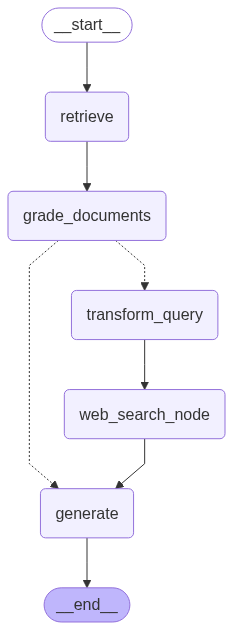

✅ Graph compiled and visualized.


In [40]:
# ------------------------------------------------
# 🕸️ Build the Graph (Nodes + Edges) and Visualize
# ------------------------------------------------
from langgraph.graph import START, END, StateGraph
from IPython.display import Image, display

# ------------------------------------------------
# 1) Initialize workflow with our GraphState
# ------------------------------------------------
workflow = StateGraph(GraphState)

# ------------------------------------------------
# 2) Register nodes
# ------------------------------------------------
workflow.add_node("retrieve", retrieve)               # fetch documents
workflow.add_node("grade_documents", grade_documents) # filter by relevance
workflow.add_node("generate", generate)               # produce final answer
workflow.add_node("transform_query", transform_query) # rewrite question
workflow.add_node("web_search_node", web_search)      # augment with web search

# ------------------------------------------------
# 3) Wire edges
# ------------------------------------------------
workflow.add_edge(START, "retrieve")
workflow.add_edge("retrieve", "grade_documents")

# Conditional: decide to generate or transform
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "transform_query": "transform_query",
        "generate": "generate",
    },
)

# After transform, do web search; then generate
workflow.add_edge("transform_query", "web_search_node")
workflow.add_edge("web_search_node", "generate")

# Finalize
workflow.add_edge("generate", END)

# ------------------------------------------------
# 4) Compile and visualize
# ------------------------------------------------
app = workflow.compile()
display(Image(app.get_graph(xray=True).draw_mermaid_png()))
print("✅ Graph compiled and visualized.")


In [42]:
# ------------------------------------------------
# ▶️ Run the CRAG-style App with Question
# ------------------------------------------------
input_state = {
    "question": "what is langchain?"
}

# Invoke the graph
result = app.invoke(input_state)

# ------------------------------------------------
# 📌 Show Final Answer
# ------------------------------------------------
print("✅ App execution completed\n")
print("💡 Final Answer:\n", result.get("generation", "").strip())

# ------------------------------------------------
# 🔄 Show Transformed Query (if rewriter was used)
# ------------------------------------------------
transformed_q = result.get("question", "")
print("\n🔄 Transformed Query:\n", transformed_q)

# ------------------------------------------------
# 🌐 Collect Sources (retriever + web search)
# ------------------------------------------------
def extract_source(md: dict) -> str:
    if not md:
        return ""
    return md.get("source") or md.get("url") or md.get("Source") or ""

seen = set()
sources = []
for doc in result.get("documents", []):
    src = extract_source(getattr(doc, "metadata", {}))
    if src and src not in seen:
        seen.add(src)
        sources.append(src)

print("\n📚 Sources:")
if sources:
    for s in sources:
        print("-", s)
else:
    print("- (no explicit source metadata available)")


--- RETRIEVE ---
✅ Retrieved 4 documents
--- CHECK DOCUMENT RELEVANCE TO QUESTION ---
--- GRADE: DOCUMENT NOT RELEVANT ---
--- GRADE: DOCUMENT NOT RELEVANT ---
--- GRADE: DOCUMENT NOT RELEVANT ---
--- GRADE: DOCUMENT NOT RELEVANT ---
--- ASSESS GRADED DOCUMENTS ---
--- DECISION: DOCS NOT RELEVANT → TRANSFORM QUERY ---
---TRANSFORM QUERY---
--- WEB SEARCH ---
--- GENERATE ---
✅ App execution completed

💡 Final Answer:
 LangChain is an open-source framework that simplifies building AI applications by providing modular components like prompts, chains, memory, and agents. It works by allowing developers to compose these components to create flexible, scalable solutions that connect language models to data and tools. This approach reduces development complexity and accelerates the creation of applications like chatbots and AI assistants.

🔄 Transformed Query:
 What is LangChain and how does it work for building AI applications?

📚 Sources:
- https://medium.com/data-engineering-with-dremio/c